# Deep Learning Course

## Assignment Four 


### Assignment Goals:

* Implementing Fully Connected AutoEncoders

* Implement naive generative model

* Understand VAE and GAN, then implement a classical generative model: VAE-GAN. 



### DataSet

In this Assignment, you will use the Fashion-MNIST dataset. The dataset is not given in the assignment package, please download/load by yourself. *Hint*: You can use  
```python
(x_train, _), (x_test, _)  = keras.datasets.fashion_mnist.load_data() 
```
to load the dataset.


### Requirements


1. **(20 points) Implement a Fully Connected AutoEncoder** 

    * Your AutoEncoder should have a bottleneck with two neurons and use Mean Squared Error (MSE) as the objective function. Design the model structure by yourself. Notice that in an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck. 

    * Train your model on MNIST. Plot the train and test loss. 

    * Randomly select 10 images from the test set, encode the selected 10 images, visualize the original images and the decoded images.


2. **(30 points) Naive generative model**

    This question is about using an AutoEncoder to generate similar but not identical hand digits. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable hand-written digit. 
    
    1. Start with your Fully Connected AutoEncoder from part 1. Try to generate new images by inputting some random numbers to the decoder (i.e. the bottleneck layer). Visualize 10 generated images. (10 points)
    
    2. Now restrict each neuron of the bottleneck layer to have a distribution with mean zeroes and variance one (i.e. $N(0, 1)$). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the randomly generated inputs to generate new images. Visualize 10 generated images. (15 points)
    
    3. Are the output images different between A) and B)? If so, why do you think this difference occurs? (5 points)


3. **(50 points) Advanced generative model**

    In this part, you are asking to implement a VAE-GAN model. A VAE-GAN is a Generative Adversarial Network whose generator is an Variational Autoencoder.Here is the paper which proposed the VAE-GAN: [**[PAPER]**](https://arxiv.org/pdf/1512.09300.pdf ). You may need to read this paper before implementing this model. 

    1. Implement a Variational Autoencoder based on your Fully Connected AutoEncoder from part 1. Use your VAE to randomly generate 10 images. Does the VAE produce a different quality of output image? (30 points)

    2. Implement a VAE-GAN based on your implemented VAE. Train the VAE-GAN. (20 points)
      * Then use your VAE-GAN to randomly generate 10 images from $p(z)$. 
      * Randomly select 10 images from the test dataset and reconstruct them using your model, then visualize the original and reconstructed images. 
      
        *Hint:* For the generation and reconstruction tasks, refer to Section 4.1 in the paper.


### Submission Notes:

Please use Jupyter Notebook. The notebook should include the final code, results, and answers. You should submit your Notebook in .pdf and .ipynb format. (penalty 10 points).

Notice that your AutoEncoders should have only one bottleneck.


**Instructions**:

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your writing or coding. You must not let other students copy your work. Spelling and grammar count.





## Your implementation

### Import Dependencies

In [1]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import random
import numpy as np

c:\Users\mikew\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### hyperparameters

In [2]:
# hyperparameters: 

epochs = 10
lr = 1e-3
batch_size = 32
bottleneck_num = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('you are training on: ', device)

you are training on:  cuda


In [3]:
bottleneck_num = 2
img_num = 10

### dataloader

In [4]:
# download dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [5]:
# test
for images, labels in trainloader:
    print(images.shape)
    for label in labels:
        print(label)
        break
    break

torch.Size([32, 1, 28, 28])
tensor(6)


### helper functions

In [5]:
def plot_loss(losses, name = None):
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(name + ' loss graph')
    plt.show()
    

In [45]:
def generate_nums(num = 10):
    rand_input = np.random.randn(num,bottleneck_num)
    return rand_input

In [46]:
def plot_images(images, num_img = 10):
    fig, axs = plt.subplots(1,num_img, figsize = (20,4))
    for i in range(num_img):
        # print(images[i].shape)
        img = images[i].to('cpu')
        img = img.detach().numpy()
        axs[i].imshow(img.squeeze(0), cmap = 'gray')
        # axs[i].set_title('Image ', i)

In [33]:
# train
def train(model, loss_fn, optimizer, num_epochs , trainloader, testloader):
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(trainloader):
            images = images.to(device)
            output_image = model(images)
            optimizer.zero_grad()
            loss = loss_fn(output_image, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss_train = total_loss / len(trainloader)
        train_losses.append(avg_loss_train)

        # valid loss

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, _ in tqdm(testloader):
                images = images.to(device)
                valid_output = model(images)
                loss = loss_fn(valid_output,images)
                valid_loss += loss.item()
        avg_loss_valid = valid_loss / len(testloader)
        valid_losses.append(avg_loss_valid)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss_train:.4f}, Test Loss: {avg_loss_valid:.4f}')

    return train_losses,valid_losses, model

### 1. Auto-Encoder

In [8]:
# define model
class AutoEncoder(nn.Module):
    def __init__(self, bottle_dim=2):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottle_dim), # Bottleneck with two neurons
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottle_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28),
            nn.Sigmoid() # Output is normalized to [0, 1]
        )

    def forward(self, x):
        x_shape = x.shape
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded.reshape(x_shape)

In [7]:
model = AutoEncoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [8]:
train_losses, valid_losses, trained_model = train(model, loss_fn, optimizer, epochs, trainloader, testloader)

100%|██████████| 313/313 [00:01<00:00, 166.92it/s]


Epoch 1/10, Train Loss: 0.0392, Test Loss: 0.0314


100%|██████████| 313/313 [00:01<00:00, 160.65it/s]


Epoch 2/10, Train Loss: 0.0306, Test Loss: 0.0298


100%|██████████| 313/313 [00:01<00:00, 189.48it/s]


Epoch 3/10, Train Loss: 0.0296, Test Loss: 0.0292


100%|██████████| 313/313 [00:02<00:00, 140.47it/s]


Epoch 4/10, Train Loss: 0.0289, Test Loss: 0.0287


100%|██████████| 313/313 [00:01<00:00, 190.25it/s]


Epoch 5/10, Train Loss: 0.0284, Test Loss: 0.0282


100%|██████████| 313/313 [00:01<00:00, 165.59it/s]


Epoch 6/10, Train Loss: 0.0281, Test Loss: 0.0283


100%|██████████| 313/313 [00:02<00:00, 132.25it/s]


Epoch 7/10, Train Loss: 0.0278, Test Loss: 0.0277


100%|██████████| 313/313 [00:02<00:00, 133.28it/s]


Epoch 8/10, Train Loss: 0.0275, Test Loss: 0.0274


100%|██████████| 313/313 [00:01<00:00, 159.87it/s]


Epoch 9/10, Train Loss: 0.0273, Test Loss: 0.0273


100%|██████████| 313/313 [00:02<00:00, 148.61it/s]

Epoch 10/10, Train Loss: 0.0271, Test Loss: 0.0270


#### Plot Loss

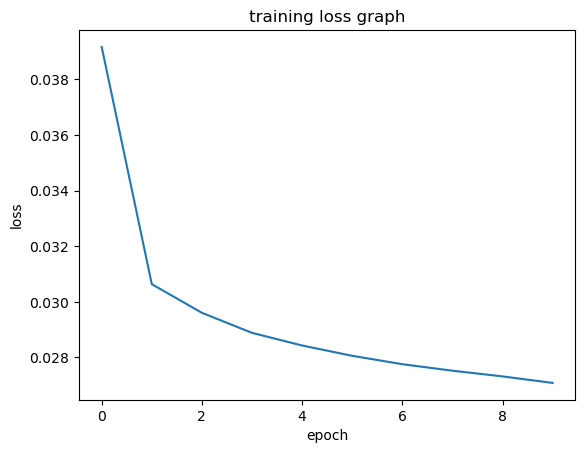

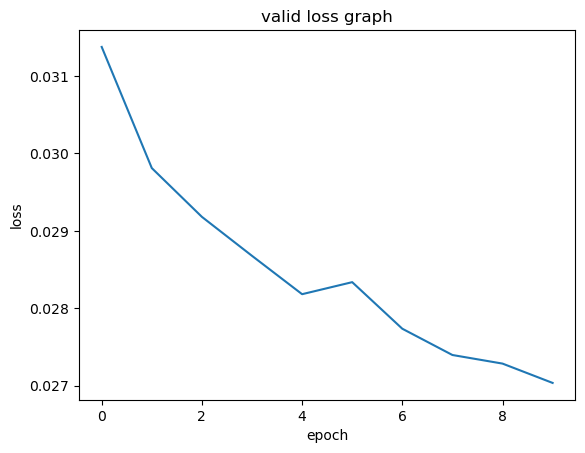

In [10]:
plot_loss(train_losses, name = 'training')
plot_loss(valid_losses, name = 'valid')

#### Visual Evaluation

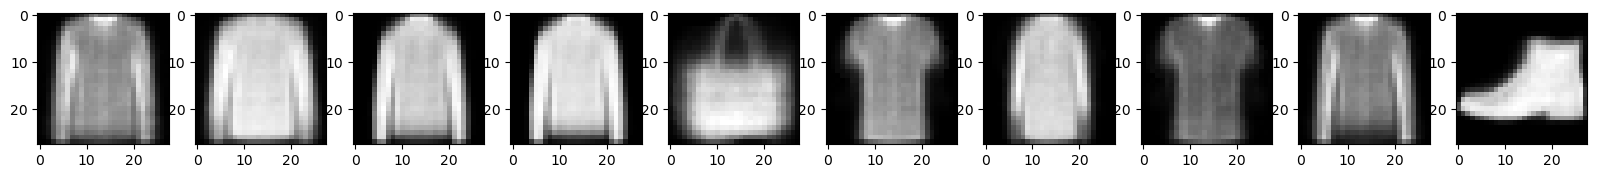

In [12]:
# draw 10 randomly selected images: 
output_images = []
trained_model.eval()
with torch.no_grad():
    for i in range(10):
        rand_int = random.randint(0, len(testset)-1)
        selected_image,_ = testset[rand_int]
        selected_image = selected_image.to(device)
        # plt.imshow(selected_image.squeeze(0))
        output_image = trained_model(selected_image)
        output_images.append(output_image)

    plot_images(output_images)
    
    
    

### 2. Naive Generative Net

#### 1. generate randomly

In [17]:
# generate images 
def generate_image(input, model):
    input = torch.tensor(input, dtype=torch.float32)
    output = model.decoder(input).reshape(1,28,28)
    return output

In [50]:
def generate_norm_nums(num=10):
    mean = np.array([0, 0])  # Mean vector
    covariance_matrix = np.eye(2)  # Covariance matrix (identity matrix for standard normal distribution)

    # Generate samples
    num_samples = num 
    samples = np.random.multivariate_normal(mean, covariance_matrix, num_samples)
    return samples

In [21]:
rand_input = generate_nums()
print(rand_input)


[[ 0.59886288  0.33176502]
 [ 0.6857675  -0.13992407]
 [-0.32327146 -0.83554053]
 [ 2.24541164  0.76338554]
 [ 0.32660059 -1.67133497]
 [ 0.39617883  1.83500299]
 [ 0.5744195  -1.4965082 ]
 [-1.4578571   0.4342719 ]
 [ 0.12995407  0.16491713]
 [-0.21136404 -1.40577233]]


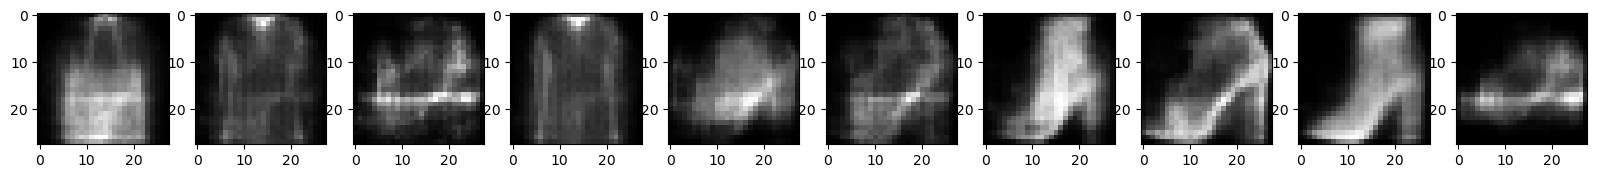

In [17]:
plot_imgs = []
for i in range(img_num):
    output_img = generate_image(rand_input[i],trained_model.to('cpu'))
    plot_imgs.append(output_img)
plot_images(plot_imgs)

#### 2. normalize bottleneck 

In [12]:
# define model with bottleneck normalization: 

class AutoEncoderNorm(nn.Module):
    def __init__(self, bottle_dim=2):
        super(AutoEncoderNorm, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, bottle_dim), # Bottleneck with two neurons
        )
        self.bn = nn.BatchNorm1d(bottle_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottle_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28),
            nn.Sigmoid() # Output is normalized to [0, 1]
        )

    def forward(self, x):
        x_shape = x.shape
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        encoded = self.encoder(x)
        batched = self.bn(encoded)
        decoded = self.decoder(batched)

        return decoded.reshape(x_shape)

In [13]:
model = AutoEncoderNorm().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
train_losses, valid_losses, trained_model = train(model, loss_fn, optimizer, epochs, trainloader, testloader)

100%|██████████| 313/313 [00:01<00:00, 200.26it/s]


Epoch 1/10, Train Loss: 0.0442, Test Loss: 0.0356


100%|██████████| 313/313 [00:01<00:00, 199.73it/s]


Epoch 2/10, Train Loss: 0.0383, Test Loss: 0.0342


100%|██████████| 313/313 [00:01<00:00, 197.18it/s]


Epoch 3/10, Train Loss: 0.0371, Test Loss: 0.0329


100%|██████████| 313/313 [00:01<00:00, 196.76it/s]


Epoch 4/10, Train Loss: 0.0364, Test Loss: 0.0318


100%|██████████| 313/313 [00:01<00:00, 201.67it/s]


Epoch 5/10, Train Loss: 0.0360, Test Loss: 0.0316


100%|██████████| 313/313 [00:01<00:00, 197.40it/s]


Epoch 6/10, Train Loss: 0.0354, Test Loss: 0.0309


100%|██████████| 313/313 [00:01<00:00, 200.02it/s]


Epoch 7/10, Train Loss: 0.0353, Test Loss: 0.0304


100%|██████████| 313/313 [00:01<00:00, 199.41it/s]


Epoch 8/10, Train Loss: 0.0351, Test Loss: 0.0306


100%|██████████| 313/313 [00:01<00:00, 171.86it/s]


Epoch 9/10, Train Loss: 0.0347, Test Loss: 0.0302


100%|██████████| 313/313 [00:01<00:00, 193.27it/s]

Epoch 10/10, Train Loss: 0.0348, Test Loss: 0.0300


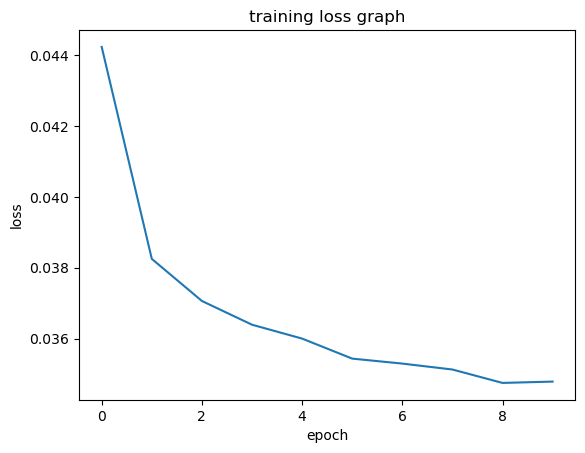

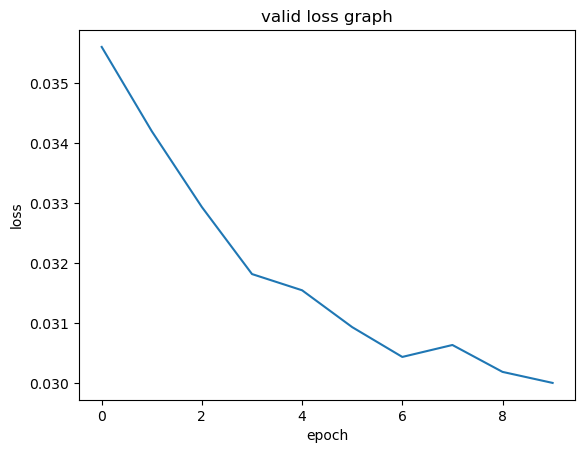

In [14]:
plot_loss(train_losses, name = 'training')
plot_loss(valid_losses, name = 'valid')

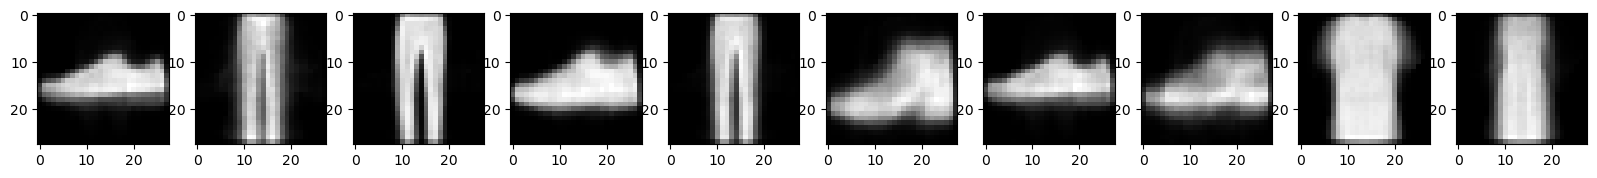

In [15]:
output_images = []
trained_model.eval()
with torch.no_grad():
    for i in range(10):
        rand_int = random.randint(0, len(testset)-1)
        selected_image,_ = testset[rand_int]
        selected_image = selected_image.to(device)
        # plt.imshow(selected_image.squeeze(0))
        output_image = trained_model(selected_image)
        output_images.append(output_image)

    plot_images(output_images)
    

In [21]:
# generate numbers: 

norm_input = generate_norm_nums()
print(norm_input)


[[ 1.4640431  -0.31822465]
 [ 0.859052   -0.95344357]
 [ 0.08278221 -0.26002204]
 [-0.62640952 -0.85359865]
 [-2.0814755  -0.65916293]
 [-0.89019548 -0.88384216]
 [-0.0990918   0.27822857]
 [-0.29251342  1.11379447]
 [ 1.65781526  2.10009257]
 [ 1.51241575 -0.27160369]]


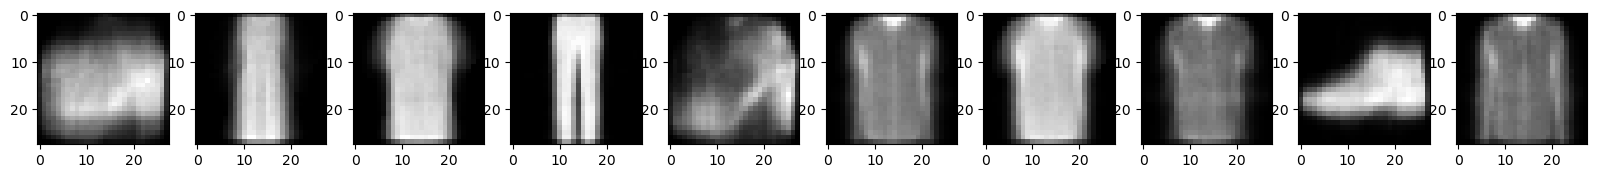

In [22]:
plot_imgs = []
for i in range(img_num):
    output_img = generate_image(rand_input[i],trained_model.to('cpu'))
    plot_imgs.append(output_img)
plot_images(plot_imgs)

3. A) and B) are different. images generated from B) is more clear than A). This is because the addition of normaliztion layer. When adding the normalization layer, the decoder is restricted to get input from 2-d vectors drawn from multi-variate standard normal distribution. Therefore, when randomly generate a 2-d vector drawn from the same distribution and pass it to the decoder, the decoder will perform better. 

### 3. Advanced Generative Net

In [6]:
# define loss function for part 3: 
def loss_fn_VAE(recon_x, x, mu, log_var):
    criterion = nn.MSELoss()
    MSE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    KLD/=batch_size*784
    return MSE + KLD


In [42]:
def generate_VAE_image(input, model, device = 'cpu'):
    input = torch.tensor(input, dtype=torch.float32).to(device)
    hidden = model.fc2(input.unsqueeze(0))
    hidden = hidden.view(-1,128,7,7)
    output = model.conv_decoder(hidden)
    return output

##### 1. VAE

In [25]:
# define model
class VAE(nn.Module):
    def __init__(self, in_channels = 1, bottle_dim=2):
        super(VAE, self).__init__()
        # define encoder: 
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), # dim: 28 -> 28
            nn.BatchNorm2d(32,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3,2,padding=1), # dim: 28->14
            nn.BatchNorm2d(64,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, padding=1), # dim: 14->7
            nn.BatchNorm2d(128,momentum=0.9),
            nn.ReLU(),
            )
        self.fc1 = nn.Sequential( 
            nn.Linear(7*7*128, 256),
            nn.BatchNorm1d(256,momentum=0.9),
            nn.ReLU(),

        )
        self.fc2 = nn.Sequential(
            nn.Linear(bottle_dim, 7*7*128),
            nn.BatchNorm1d(7*7*128,momentum=0.9),
            nn.ReLU(),

        )
        self.conv_decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,2,padding=1, output_padding=1),
            nn.BatchNorm2d(64,momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,2,padding=1, output_padding=1),
            nn.BatchNorm2d(32,momentum=0.9),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 3,padding=1),
            nn.Sigmoid()
        )
        self.mu = nn.Linear(256, bottle_dim)
        self.log_var = nn.Linear(256,bottle_dim)
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        random_noise = torch.randn_like(std)
        return mu + random_noise * std
    def forward(self,x):
        batch_s = x.size()[0]
        encoded = self.conv_encoder(x) # dim: 7*7*256
        # encoded_shape = encoded.shape
        latent = encoded.view(batch_s,-1)
        latent = self.fc1(latent) 
        # output dimension: batch * 256
        mu = self.mu(latent)
        log_var = self.log_var(latent)
        hidden = self.reparameterize(mu, log_var)
        # output dim: batch*bottle_dim
        hidden = self.fc2(hidden)
        hidden = hidden.view(-1,128,7,7)
        decoded = self.conv_decoder(hidden)
        return decoded, mu, log_var #, encoded_shape
        

In [33]:
# define training function for part 3: 
def train_VAE(model, optimizer, trainloader, testloader, num_epochs=20):
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(trainloader):
            images = images.to(device)
            decoded, mu, log_var= model(images)
            loss = loss_fn_VAE(decoded, images, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss_train = total_loss / len(trainloader)
        train_losses.append(avg_loss_train)

        # valid loss

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, _ in tqdm(testloader):
                images = images.to(device)
                decoded, mu, log_var = model(images)
                loss = loss_fn_VAE(decoded,images, mu, log_var)
                valid_loss += loss.item()
        avg_loss_valid = valid_loss / len(testloader)
        valid_losses.append(avg_loss_valid)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss_train:.4f}, Test Loss: {avg_loss_valid:.4f}')

    return train_losses,valid_losses, model
    

In [34]:
# defince model and configs
model_VAE = VAE().to(device)
optimizer = optim.Adam(model_VAE.parameters(), lr = 1e-5)
train_losses, valid_losses, trained_model = train_VAE(model_VAE, optimizer, trainloader, testloader)

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:02<00:00, 139.27it/s]


Epoch 1/20, Train Loss: 0.0901, Test Loss: 0.0539


100%|██████████| 313/313 [00:02<00:00, 156.13it/s]


Epoch 2/20, Train Loss: 0.0507, Test Loss: 0.0476


100%|██████████| 313/313 [00:02<00:00, 151.76it/s]


Epoch 3/20, Train Loss: 0.0461, Test Loss: 0.0478


100%|██████████| 313/313 [00:03<00:00, 91.43it/s]


Epoch 4/20, Train Loss: 0.0443, Test Loss: 0.0422


100%|██████████| 313/313 [00:01<00:00, 173.02it/s]


Epoch 5/20, Train Loss: 0.0432, Test Loss: 0.0455


100%|██████████| 313/313 [00:01<00:00, 170.39it/s]


Epoch 6/20, Train Loss: 0.0427, Test Loss: 0.0410


100%|██████████| 313/313 [00:01<00:00, 161.58it/s]


Epoch 7/20, Train Loss: 0.0423, Test Loss: 0.0447


100%|██████████| 313/313 [00:01<00:00, 169.19it/s]


Epoch 8/20, Train Loss: 0.0418, Test Loss: 0.0456


100%|██████████| 313/313 [00:02<00:00, 147.87it/s]


Epoch 9/20, Train Loss: 0.0414, Test Loss: 0.0417


100%|██████████| 313/313 [00:01<00:00, 171.09it/s]


Epoch 10/20, Train Loss: 0.0412, Test Loss: 0.0395


100%|██████████| 313/313 [00:01<00:00, 166.44it/s]


Epoch 11/20, Train Loss: 0.0407, Test Loss: 0.0425


100%|██████████| 313/313 [00:01<00:00, 160.90it/s]


Epoch 12/20, Train Loss: 0.0406, Test Loss: 0.0406


100%|██████████| 313/313 [00:01<00:00, 161.47it/s]


Epoch 13/20, Train Loss: 0.0403, Test Loss: 0.0381


100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


Epoch 14/20, Train Loss: 0.0401, Test Loss: 0.0387


100%|██████████| 313/313 [00:02<00:00, 151.78it/s]


Epoch 15/20, Train Loss: 0.0399, Test Loss: 0.0376


100%|██████████| 313/313 [00:02<00:00, 136.16it/s]


Epoch 16/20, Train Loss: 0.0397, Test Loss: 0.0389


100%|██████████| 313/313 [00:02<00:00, 138.95it/s]


Epoch 17/20, Train Loss: 0.0397, Test Loss: 0.0393


100%|██████████| 313/313 [00:02<00:00, 133.59it/s]


Epoch 18/20, Train Loss: 0.0396, Test Loss: 0.0421


100%|██████████| 313/313 [00:02<00:00, 155.30it/s]


Epoch 19/20, Train Loss: 0.0394, Test Loss: 0.0374


100%|██████████| 313/313 [00:02<00:00, 155.48it/s]

Epoch 20/20, Train Loss: 0.0393, Test Loss: 0.0375


In [56]:

rand_input = generate_norm_nums()
print(rand_input)

[[-0.69723777 -0.42427265]
 [-0.30523351 -0.87435817]
 [ 1.7809977   0.54332961]
 [-1.59168617  0.74610887]
 [ 1.15505797 -0.51771755]
 [ 0.57965833  0.76277957]
 [ 0.30876477 -0.60766888]
 [-0.43013751 -0.08981339]
 [ 1.00790122  0.88548555]
 [-0.04089743 -0.68661904]]


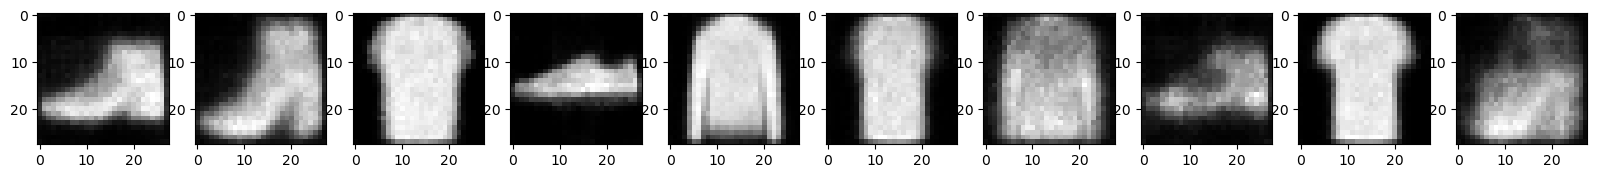

In [57]:
plot_imgs = []
for i in range(img_num):
    output_img = generate_VAE_image(rand_input[i],trained_model.to('cpu'))
    plot_imgs.append(output_img.squeeze(0))
plot_images(plot_imgs)

##### 2. VAE-GAN

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, class_num=1):
        super(Discriminator, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, 32,kernel_size=5, padding=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 128, kernel_size=5,stride=2, padding=2), # 28->14
            nn.BatchNorm2d(128,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=2), # 14->7
            nn.BatchNorm2d(256,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(256,256, 5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
            # output dim: 7*7*256
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(7*7*256, 512),
            nn.BatchNorm1d(512,momentum=0.9),
            nn.ReLU(),
            nn.Linear(512,class_num)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv_layer(x) # dim: 7*7*256
        x = x.view(-1, 7*7*256)
        x1 = x
        x = self.fc_layer(x)
        x = self.sigmoid(x)
        return x,x1

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, bottle_dim=2):
        super(Encoder,self).__init__()
        self.conv1=nn.Conv2d(in_channels, 32, 3, padding=1)   #in_channels=1
        self.bn1=nn.BatchNorm2d(32,momentum=0.9)
        self.conv2=nn.Conv2d(32, 64, 3,2,padding=1)
        self.bn2=nn.BatchNorm2d(64,momentum=0.9)
        self.conv3=nn.Conv2d(64, 128, 3, 2, padding=1)
        self.bn3=nn.BatchNorm2d(128,momentum=0.9)
        self.relu=nn.ReLU()
        self.fc1=nn.Linear(128*7*7,256)
        self.bn4=nn.BatchNorm1d(256,momentum=0.9)
        self.fc_mean=nn.Linear(256,bottle_dim)
        self.fc_logvar=nn.Linear(256,bottle_dim)   #latent dim=2
    def forward(self,x):
        batch_size=x.size()[0]
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.relu(self.bn2(self.conv2(out)))
        out=self.relu(self.bn3(self.conv3(out)))
        out=out.view(batch_size,-1)
        out=self.relu(self.bn4(self.fc1(out)))
        mean=self.fc_mean(out)
        logvar=self.fc_logvar(out)

        return mean,logvar

In [8]:
class Decoder(nn.Module):
  def __init__(self, out_channels=1, bottle_dim=2 ):
    super(Decoder,self).__init__()
    self.fc1=nn.Linear(bottle_dim,7*7*128)
    self.bn1=nn.BatchNorm1d(7*7*128,momentum=0.9)
    self.relu=nn.ReLU()
    self.deconv1=nn.ConvTranspose2d(128,64,6, stride=2, padding=2) # 7->14
    self.bn2=nn.BatchNorm2d(64,momentum=0.9)
    self.deconv2=nn.ConvTranspose2d(64,32,6, stride=2, padding=2) # 14->28
    self.bn3=nn.BatchNorm2d(32,momentum=0.9)
    self.deconv4=nn.ConvTranspose2d(32,out_channels,5, stride=1, padding=2) # 28->28
    self.sigmoid=nn.Sigmoid()

  def forward(self,x):
    x=self.relu(self.bn1(self.fc1(x)))
    x=x.view(-1,128,7,7)
    x=self.relu(self.bn2(self.deconv1(x)))
    x=self.relu(self.bn3(self.deconv2(x)))
    x=self.sigmoid(self.deconv4(x))
    return x

In [9]:
class VAE_GAN(nn.Module):
    def __init__(self, bottle_dim=2):
        super(VAE_GAN,self).__init__()
        self.bottle_dim = bottle_dim
        self.encoder=Encoder()
        self.decoder=Decoder()
        self.discriminator=Discriminator()


    def forward(self,x):
        batch_size = x.size()[0]
        z_mean, z_logvar=self.encoder(x)
        std = torch.exp(0.5 * z_logvar)
            
        #sampling epsilon from normal distribution
        epsilon=torch.randn(batch_size,self.bottle_dim).to(device)
        z=z_mean+std*epsilon
        x_tilda=self.decoder(z)
        
        return z_mean,z_logvar,x_tilda

In [18]:
gen=VAE_GAN().to(device)
discrim=Discriminator().to(device)

In [20]:
epochs=5
lr=3e-4
alpha=0.1
gamma=15
batch_size = 32

In [11]:
len(next(iter(trainloader)))

2

In [21]:
criterion=nn.BCELoss().to(device)
optim_E=optim.RMSprop(gen.encoder.parameters(), lr=lr)
optim_D=optim.RMSprop(gen.decoder.parameters(), lr=lr)
optim_Dis=optim.RMSprop(discrim.parameters(), lr=lr*alpha)
# z_fixed=torch.randn((64,128)).to(device)
# x_fixed=Variable(real_batch[0]).to(device)

In [22]:
#train 
for epoch in range(epochs):
  total_gan_loss = 0
  for image, _ in tqdm(trainloader):
    batch_s=image.size()[0]
    
    real_label=torch.ones(batch_s,1).to(device)
    fake_label=torch.zeros(batch_s,1).to(device)
    image = image.to(device)
    mean, logvar, generated_img = gen(image)
    z_p = torch.randn(32,bottleneck_num).to(device)
    x_p_tilda = gen.decoder(z_p)

    output = discrim(image)[0]
    errD_real = criterion(output, real_label)
    output= discrim(generated_img)[0]
    errD_rec_enc = criterion(output, fake_label)
    output= discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, fake_label)
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    optim_Dis.zero_grad()
    gan_loss.backward(retain_graph=True)
    optim_Dis.step()


    output = discrim(image)[0]
    errD_real = criterion(output, real_label)
    output = discrim(generated_img)[0]
    errD_rec_enc = criterion(output, fake_label)
    output = discrim(x_p_tilda)[0]
    errD_rec_noise = criterion(output, fake_label)
    gan_loss = errD_real + errD_rec_enc + errD_rec_noise
    

    x_l_tilda = discrim(generated_img)[1]
    x_l = discrim(image)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    err_dec = gamma * rec_loss - gan_loss 
    optim_D.zero_grad()
    err_dec.backward(retain_graph=True)
    optim_D.step()
    
    mean, logvar, generated_img = gen(image)
    x_l_tilda = discrim(generated_img)[1]
    x_l = discrim(image)[1]
    rec_loss = ((x_l_tilda - x_l) ** 2).mean()
    prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()
    prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)
    err_enc = prior_loss + 5*rec_loss

    optim_E.zero_grad()
    err_enc.backward(retain_graph=True)
    optim_E.step()
    total_gan_loss += gan_loss.item()
  avg_gan_loss = total_gan_loss/len(trainloader)  
  print(f'{epoch+1}/{epochs}\tLoss_gan: {avg_gan_loss:.4f}')


100%|██████████| 1875/1875 [02:08<00:00, 14.54it/s]


1/5	Loss_gan: 0.7249


100%|██████████| 1875/1875 [02:39<00:00, 11.76it/s]


2/5	Loss_gan: 0.1776


100%|██████████| 1875/1875 [03:08<00:00,  9.93it/s]


3/5	Loss_gan: 0.0936


100%|██████████| 1875/1875 [03:13<00:00,  9.68it/s]


4/5	Loss_gan: 0.0647


100%|██████████| 1875/1875 [03:13<00:00,  9.69it/s]

5/5	Loss_gan: 0.0388


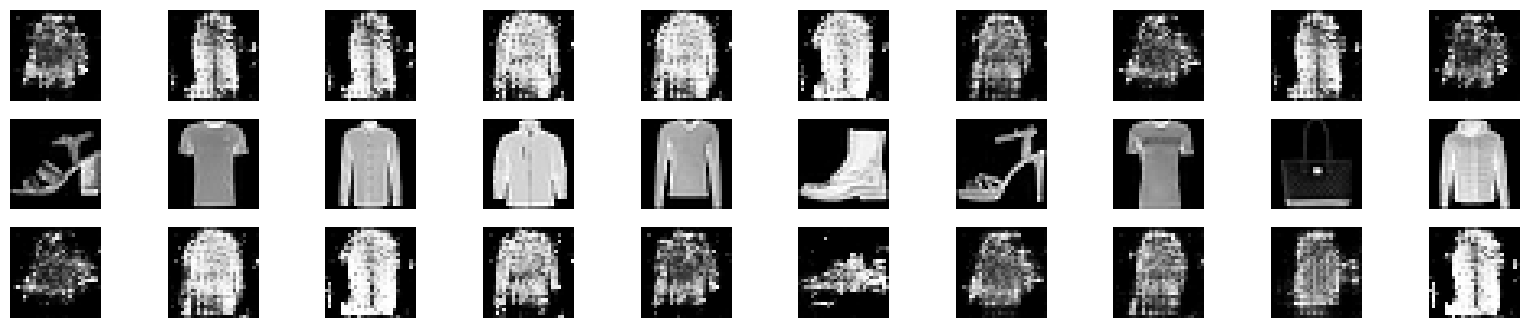

In [24]:
''' visualization: 
first row: randomly generated image 
second row: original image
third row: corresponding reconstructed image from second row
'''
gen.eval()
indices = random.sample(range(len(testset)),10)
images = torch.stack([testset[i][0] for i in indices]).to(device)
z_p = torch.randn(10,bottleneck_num).to(device)
with torch.no_grad():
    _,_,out_img = gen(images)
    x_p_tilda = gen.decoder(z_p)
images = images.cpu().numpy()
out_img = out_img.cpu().numpy()
x_p_tilda = x_p_tilda.cpu().numpy()

fig, axs = plt.subplots(3, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x_p_tilda[i].squeeze(0), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(images[i].squeeze(0), cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(out_img[i].squeeze(0), cmap='gray')
    axs[2, i].axis('off')

plt.show()